# Brainstation Final Project, Toronto Housing Prices

In [337]:
from typing import Union

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
pio.renderers.default = "vscode"

pd.set_option('plotting.backend', 'plotly')
pd.options.mode.chained_assignment = None  # default='warn'

## Loading the Datasets

I scraped 3 sites, all of which have similar listings. I will choose which one to use based on some factors.

In [33]:
trreb = pd.read_csv('data/trreb-jan17.csv', parse_dates=['added_at'])
realtor = pd.read_csv('data/realtorca-jan17.csv')
zoocasa = pd.read_csv('data/zoocasa-jan17.csv', parse_dates=['added_at'])

In [34]:
f"Dataset # of Rows: Trreb: {trreb.shape[0]}, Realtor.ca: {realtor.shape[0]}, Zoocasa: {zoocasa.shape[0]}"

'Dataset # of Rows: Trreb: 1495, Realtor.ca: 4046, Zoocasa: 3856'

Trreb has far less entries than the other two so I will not be using it for the model.

In [35]:
# Zoocasa has entries with "0 Room totals"
zoocasa['rooms_total'].replace(0.0, np.nan, inplace=True)

In [36]:
# Realtor.ca has more entries but also an inconvenient issue where the internal square footage is not included, but the room dimensions are
# this wouldn't be too hard to calculate but some rooms are missing, which was yield skewed results with our model.
realtor['room_dim_list'][0]

"19'4'' x 11'5'',14'8'' x 8'4'',8'9'' x 11'9'',4'10'' x 5'6'',5'5'' x 4'5'',15'0'' x 11'9''"

In [37]:
# Instead of a NaN value, the dataset comes out like this for rooms without available dimensions so I need to fix that.
realtor.room_dim_list[117]

'Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available'

In [38]:
realtor['room_dim_list_fixed'] = realtor['room_dim_list'].str.replace('Measurements not available,', '').replace('Measurements not available', '')
realtor['room_dim_list_fixed'].replace('', np.nan, regex=True, inplace=True)
realtor.room_dim_list_fixed[117]

nan

In [39]:
z_potential_features = ['price', 'bedrooms', 'bedrooms_partial', 'bathrooms', 'bathrooms_partial', 'square_footage_min', 'square_footage_max', 'parking', 'type', 'garage_type', 'exterior', 'driveway_type', 'basement_type', 'features', 'levels', 'rooms_total', 'desc']
r_potential_features = ['price', 'bedrooms', 'bathrooms', 'archi_style', 'room_dim_list_fixed', 'parking', 'parking_type','type', 'exterior', 'utility', 'basement_type', 'features', 'levels', 'rooms_total', 'public_desc', 'heating']

## Counting NaN Values to Compare Datasets

In [40]:
# Realtor.ca
fig = px.bar(
    data_frame=realtor[r_potential_features].isna().sum(), 
    labels={'value': '# of NaN values', 'index': 'Features'},
    title="Realtor.ca NaN Count"
)
fig.update_layout(showlegend=False)
fig.show()

# Zoocasa
fig = px.bar(
    data_frame=zoocasa[z_potential_features].isna().sum(), 
    labels={'value': '# of NaN values', 'index': 'Features'},
    title="Zoocasa NaN Count"
)
fig.update_layout(showlegend=False)
fig.show()

Realtor.ca is missing almost all of its parking data, as well as its levels and architectural style. These are pretty essential for my model. As for the square footage, it is pretty similar for both sets of data. From this alone, I have chosen to use the Zoocasa data

In [41]:
# Second Zoocasa dataset, partially scraped 9 days after the first one.
zoocasa_2 = pd.read_csv('data/zoocasa-jan26.csv', parse_dates=['added_at'])
zoocasa_2['rooms_total'].replace(0.0, np.nan, inplace=True)

In [42]:
zoocasa_concat = pd.concat([zoocasa, zoocasa_2], axis=0)
zoocasa_concat.drop_duplicates(subset='mls_num', keep='first', inplace=True)
zoocasa_concat.reset_index(drop=True, inplace=True)
f"Second scrape added: {zoocasa_concat.shape[0] - zoocasa.shape[0]} listings"

'Second scrape added: 485 listings'

In [43]:
# Removing all listings added before 2022, not relevant
df = zoocasa_concat[(zoocasa_concat['added_at'].dt.year == 2022) | (zoocasa_concat['added_at'].dt.year == 2023)]

In [44]:
df = df[~df['square_footage_max'].isna() & ~df['square_footage_min'].isna()]
df = df[~df['rooms_total'].isna()]

In [45]:
df['fsa'] = df['postal_code'].str.slice(0,3)
df['bedrooms_partial'] = df['bedrooms_partial'].fillna(0)

In [46]:
df['fsa'].unique()

array(['M9M', 'M5A', 'M8V', 'M4S', 'M6M', 'M5S', 'M4Y', 'M1G', 'M4P',
       'M8Y', '000', 'M6P', 'M6E', 'M4V', 'M1E', 'M4L', 'M8X', 'M6K',
       'M2J', 'M5P', 'M5V', 'M4C', 'M1W', 'M5E', 'M1P', 'M9N', 'M2N',
       'M3A', 'M5R', 'M9R', 'M2R', 'M1M', 'M2M', 'M9V', 'M5J', 'M4W',
       'M1S', 'M4E', 'M6L', 'M6N', 'M6C', 'M9B', 'M3C', 'M1K', 'M3N',
       'M6B', 'M1B', 'M1J', 'M8Z', 'M9A', 'M6R', 'M1R', 'M3M', 'M8W',
       'M5M', 'M5G', 'M5T', 'M5B', 'M5C', 'M6J', 'M2H', 'M9C', 'M3J',
       'M2K', 'M6H', 'M3H', 'M4N', 'M4A', 'M9L', 'M6S', 'M4G', 'M6G',
       'M1N', 'M6A', 'M3K', 'M4K', 'M2P', 'M9W', 'M1T', 'M1V', 'M2L',
       'M1H', 'M4M', 'M3B', 'M5H', 'M1L', 'M9P', 'M5N', 'M4R', 'M1C',
       'M2S', 'M4T', 'M4B', 'M4H', 'M4J', 'M4X', 'M1X', 'L4J', 'TBA',
       'M3L', 'XXX', 'L9J', 'M2E', 'L1T', 'L9Y'], dtype=object)

In [47]:
df = df[df['fsa'] != 'XXX']

In [48]:
df.loc[:,~df.columns.isin(['id', 'bathrooms_partials', 'bedrooms_partials', 'lat', 'lon', 'neighbourhood_id'])].describe()

,price,bedrooms,bedrooms_partial,bathrooms,bathrooms_partial,square_footage_min,square_footage_max,parking,rooms_total
count,3.147000e+03,3147.000000,3147.000000,3147.000000,4.00,3147.000000,3147.000000,3143.000000,3147.000000
mean,1.073980e+06,1.935176,0.464887,1.959009,0.25,1027.281220,1250.650143,1.535635,6.276772
std,9.484472e+05,1.008038,0.584519,1.088534,0.50,702.009717,866.576028,13.159508,2.196044
min,1.000000e+00,0.000000,0.000000,1.000000,0.00,0.000000,499.000000,0.000000,1.000000
25%,6.194440e+05,1.000000,0.000000,1.000000,0.00,600.000000,699.000000,1.000000,5.000000
50%,7.589000e+05,2.000000,0.000000,2.000000,0.00,900.000000,999.000000,1.000000,6.000000
75%,1.139000e+06,2.000000,1.000000,2.000000,0.25,1200.000000,1399.000000,1.000000,7.000000
max,1.777500e+07,9.000000,5.000000,8.000000,1.00,4750.000000,5000.000000,706.000000,13.000000


The parking maximum is way too high and the minimum price is far too low. So I will have to clean those up

In [49]:
# deleting any parking number that is above 3 standard deviations from the mean. 
# There are no negative "parking spots" so I only need to check in the positive direction
df = df[df['parking'] < (df['parking'].describe()['std']*3 + df['parking'].describe()['mean'])]
df['parking'].describe()

count    3139.000000
mean        1.207232
std         1.296223
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        12.000000
Name: parking, dtype: float64

In [50]:
# I just kind of arbitrarily decided that any property under $200 000 in Toronto is an outlier
df = df[df['price'] > 200000]
df['price'].describe()

count    3.135000e+03
mean     1.076010e+06
std      9.493386e+05
min      2.340000e+05
25%      6.199000e+05
50%      7.590000e+05
75%      1.142400e+06
max      1.777500e+07
Name: price, dtype: float64

In [51]:
f"# of Valid Rows: {df.shape[0]}"

'# of Valid Rows: 3135'

## Grouping Common Values
For the textual portions of the data, a lot of the categories can be grouped together. I will be looking at the unique values in a couple different columns and grouping them together if they are similar enough / they are not confounding.

In [52]:
df['type'].value_counts()

Condo Apt             2409
Detached               272
Condo Townhouse        223
Comm Element Condo      77
Semi-Detached           60
Att/Row/Twnhouse        40
Co-Op Apt               15
Co-Ownership Apt        11
Leasehold Condo          8
Triplex                  5
Duplex                   4
Multiplex                3
Store W/Apt/Offc         2
Attached                 2
Link                     1
Fourplex                 1
Det Condo                1
Name: type, dtype: int64

In [53]:
df['type'].replace(['Comm Element Condo', 'Det Condo', ], 'Condo Apt', inplace=True)
df['type'].replace(['Co-Ownership Apt'], 'Co-Op Apt', inplace=True)
df['type'].replace(['Duplex', 'Triplex', 'Fourplex'], 'Multiplex', inplace=True)
df = df[df['type'] != 'Store W/Apt/Offc']
df = df[df['type'] != 'Link']
df.type.value_counts()

Condo Apt           2487
Detached             272
Condo Townhouse      223
Semi-Detached         60
Att/Row/Twnhouse      40
Co-Op Apt             26
Multiplex             13
Leasehold Condo        8
Attached               2
Name: type, dtype: int64

In [54]:
df['levels'].replace('Bungalow-Raised', 'Bungalow', inplace=True)
df['levels'].replace(['Multi-Level', 'Condo/Apt Unit', 'Bachelor/Studio'], 'Apartment', inplace=True)
df = df[df['levels'] != "Other"]
df.levels.value_counts()

Apartment          2401
2-Storey            358
3-Storey            135
Stacked Townhse      75
Loft                 66
Bungalow             47
2 1/2 Storey         23
1 1/2 Storey         12
Sidesplit 4           4
Backsplit 4           3
Sidesplit 3           2
Backsplit 3           1
Sidesplit 5           1
Name: levels, dtype: int64

In [55]:
df['basement_type'].value_counts()

None                           2575
Finished                        146
Finished and Sep Entrance        56
Fin W/O                          46
Other                            39
Apartment                        36
Finished and Full                21
Fin W/O and Sep Entrance         19
Apartment and Sep Entrance       19
Finished and Walk-Up             16
Unfinished                       13
Full and Unfinished              10
Apartment and None                9
Apartment and Fin W/O             8
Sep Entrance and Finished         8
Part Fin                          7
Full                              7
Apartment and Finished            5
Unfinished and Full               4
Sep Entrance and Fin W/O          3
Finished and W/O                  3
Unfinished and W/O                3
Walk-Up and Finished              3
Fin W/O and Full                  3
None and Other                    3
W/O                               3
Fin W/O and Walk-Up               2
Full and Sep Entrance       

In [56]:
df.loc[df['basement_type'].str.contains('Apartment', na=False), 'basement_type'] = 'None'
df.loc[df['basement_type'].str.contains('Other', na=False), 'basement_type'] = 'None'
df.loc[df['basement_type'].str.contains('None and Other', na=False), 'basement_type'] = 'None'
df.loc[df['basement_type'].str.contains('Fin', na=False), 'basement_type'] = 'Finished'
df.loc[df['basement_type'].str.contains('Finished', na=False), 'basement_type'] = 'Finished'
df.loc[df['basement_type'].str.contains('Unfinished', na=False), 'basement_type'] = 'Unfinished'
df.loc[df['basement_type'].str.contains('Part Bsmt', na=False), 'basement_type'] = 'Unfinished'
df.loc[df['basement_type'].str.contains('Sep Entrance', na=False), 'basement_type'] = 'Sep Entrance'
df.loc[df['basement_type'].str.contains('W/O', na=False), 'basement_type'] = 'Sep Entrance'
df.loc[df['basement_type'].str.contains('Walk-Up', na=False), 'basement_type'] = 'Sep Entrance'
df.loc[df['basement_type'].str.contains('Full', na=False), 'basement_type'] = 'Finished'
df.loc[df['basement_type'].str.contains('Half', na=False), 'basement_type'] = 'None'
df.loc[df['basement_type'].str.contains('Crawl Space', na=False), 'basement_type'] = 'None'

In [94]:
df['basement_type'].value_counts()

None            2707
Finished         356
Unfinished        36
Sep Entrance      13
Name: basement_type, dtype: int64

In [57]:
# Unsure of what to do with exterior yet, does a condo's exterior affect its price?
df['exterior'].value_counts()

Concrete                    1275
Brick                        934
Brick and Concrete           295
Brick and Stone               66
Other                         61
                            ... 
Insulbrick                     1
Other and Stucco/Plaster       1
Stone and Vinyl Siding         1
Brick and Alum Siding          1
Stone and Wood                 1
Name: exterior, Length: 67, dtype: int64

In [58]:
numerical_features = ['bedrooms', 'bathrooms', 'square_footage_min', 'square_footage_max', 'parking', 'rooms_total']

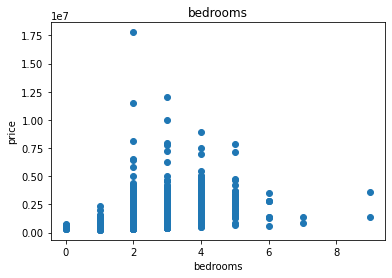

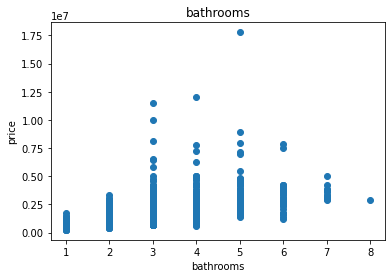

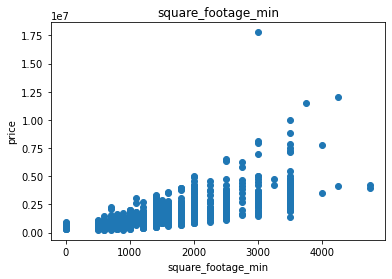

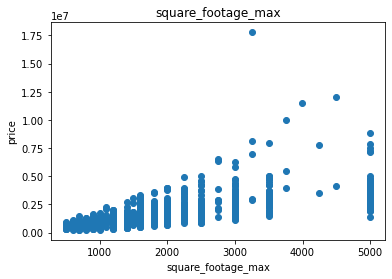

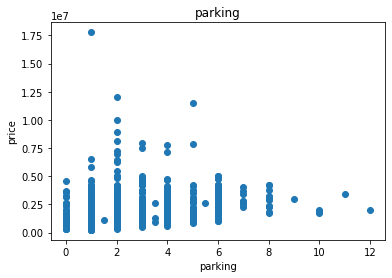

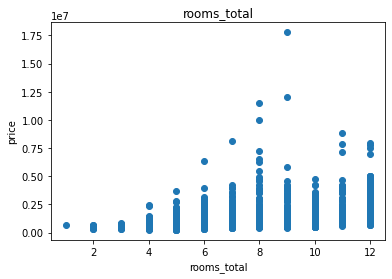

In [59]:
# pairplot is a good idea with this one
for feature in numerical_features:
    plt.scatter(x=df[feature], y=df["price"])
    plt.title(feature)
    plt.ylabel('price')
    plt.xlabel(feature)
    plt.show()

In [60]:
f"{df['fsa'].nunique()} zones/neighbourhoods"

'104 zones/neighbourhoods'

In [61]:
df['features']

0                                                     NaN
1       Stainless Steel (Gas Cooktop, Fridge, Built-In...
4       Stainless Steel (Fridge, Stove, Microwave & Bu...
5       Extras: Fridge Stove, Dishwasher, Microwave, W...
7       All Existing S/S Fridge,Stove,B/I Dishwasher, ...
                              ...                        
4335    Built-In Appliances, Laundry & Dryer, Elfs, Wi...
4336    All Elfs, Fridge, Stove, Range Hood, B/I Dishw...
4337    New Vinyl Floor, New Ss Fridge, New Stove, New...
4338    Dishwasher,Gas Cooktop,2 Bsmt Cooktops,All Elf...
4340    Built In Fridge, Stove, Dishwasher, Washer, Dr...
Name: features, Length: 3128, dtype: object

In [62]:
features = ['price', 'bedrooms', 'bedrooms_partial', 'bathrooms', 'square_footage_min', 'square_footage_max', 'parking', 'type', 'levels', 'rooms_total', 'fsa']

In [63]:
fig = px.imshow(df[features].corr())
fig.show()

# Creating the Model!

## Model Notes:

First iteration of the model was 80% accurate. It included houses and only properties under 4 000 000 dollars. Next model I am thinking of only doing condos as I don't believe I have enough data to accurately predict house price too.

In [224]:
# features = ['price', 'bedrooms', 'bedrooms_partial', 'bathrooms', 'square_footage_min', 'square_footage_max', 'parking', 'type', 'garage_type', 'exterior', 'basement_type', 'levels', 'rooms_total', 'fsa']
# features = ['price', 'bedrooms', 'bedrooms_partial', 'bathrooms', 'square_footage_min', 'square_footage_max', 'parking', 'type', 'levels', 'rooms_total', 'segment']
features = ['price', 'bedrooms', 'bedrooms_partial', 'bathrooms', 'square_footage_min', 'square_footage_max', 'parking', 'type', 'levels', 'rooms_total', 'fsa']

In [225]:
# Prizm Segmentation

# prizm = pd.read_csv('prizm.csv')
# prizm.replace('The postal code provided is not assigned to a segment. Please enter a residential postal code.', np.nan, inplace=True)
# prizm.replace('The postal code provided is invalid. Please enter a residential postal code.', np.nan, inplace=True)

# prizm.dropna(subset='segment', inplace=True)
# df_segment = df[df['postal_code'].isin(prizm['postal_code'])].reset_index(drop=True)

# segments = []
# for index, row in df_segment.iterrows():
#     segments.append(prizm[prizm['postal_code'] == row['postal_code']]['segment'].item())
# df_segment['segment'] = pd.Series(segments)

In [226]:
model_df = df[features]
model_df = model_df[model_df['price'] <= 4000000].reset_index(drop=True)
X = model_df.drop(columns='price')
y = model_df['price']

In [227]:
X = pd.get_dummies(data=X, drop_first=True)

In [228]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # test data
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=1) # val data

In [229]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [230]:
lr.fit(X_train, y_train)

LinearRegression()

In [231]:
c = lr.intercept_
m = lr.coef_

In [232]:
y_predictions = lr.predict(X_train)

In [233]:
# 70% accuracy including houses over $4000000, 80% excluding them
# 75% accuracy using segments instead of FSA
from sklearn.metrics import r2_score
r2_score(y_train, y_predictions)

0.8249720425440102

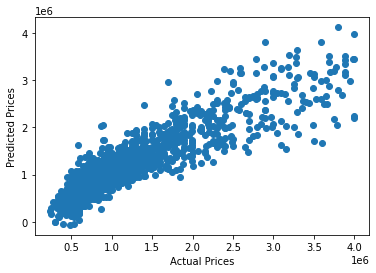

In [234]:
plt.scatter(y_train, y_predictions)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

In [235]:
y_pred_test = lr.predict(X_test)

In [236]:
r2_score(y_test, y_pred_test)

0.7834649601829201

In [237]:
px.scatter(x=y_test, y=y_pred_test, trendline='ols')

# Let's Make Some Functions!

The first few functions will be the data loading & cleaning functions

These include: format_zoocasa(), group_zoocasa(), concat_zoocasa() and load_zoocasa()

In [577]:
def format_zoocasa(df: pd.DataFrame, condos_only: bool) -> pd.DataFrame:
    """This function formats the scraped Zoocasa data in numerous ways.

    Args:
        df (pd.DataFrame): your scraped Zoocasa dataframe
        condos_only (bool): keep only condos

    Returns:
        pd.DataFrame: a formatted Zoocasa dataframe
    """
    # replacing 0 room totals with NaN values
    df['rooms_total'].replace(0.0, np.nan, inplace=True)

    # Removing all listings added before 2022, not relevant
    df = df[(df['added_at'].dt.year == 2022) | (df['added_at'].dt.year == 2023)]

    # Removing all null sqft and total rooms
    df = df[~df['square_footage_max'].isna() & ~df['square_footage_min'].isna()]
    df = df[~df['rooms_total'].isna()]

    # Creating a square footage column with the average of min and max
    df['square_footage'] = df[['square_footage_min', 'square_footage_max']].mean(axis=1)

    # Filling partial bedroom nulls with 0
    df['bedrooms_partial'] = df['bedrooms_partial'].fillna(0)
    
    # adding all partial bedrooms to bedrooms column with half value
    df['bedrooms'] = df['bedrooms'] + (df['bedrooms_partial']/2)

    # Creating FSA Column
    df['fsa'] = df['postal_code'].str.slice(0,3)
    df = df[df['fsa'] != 'XXX'] # if listing has no postal code

    # deleting any parking number that is above 3 standard deviations from the mean. 
    # There are no negative "parking spots" so I only need to check in the positive direction
    df = df[df['parking'] < (df['parking'].describe()['std']*3 + df['parking'].describe()['mean'])]

    # I just kind of arbitrarily decided that any property under $200 000 in Toronto is an outlier
    df = df[df['price'] > 200000]

    # Included Condo Types: Condo Apt, Condo Townhouse, Comm Element Condo, 
    # Excluded Condo Types (Not enough data points): Co-Op Apt, Co-Ownership Apt, Leasehold Condo

    if condos_only:
        KEEP = ['Condo Apt', 'Condo Townhouse', 'Comm Element Condo']
        df = df[df['type'].isin(KEEP)]

    return df

In [578]:
def group_zoocasa(df: pd.DataFrame, condos_only: bool) -> pd.DataFrame:
    """Groups together the 'type' and 'levels' columns to reduce number of features.

    Args:
        df (pd.DataFrame): formatted Zoocasa listing dataframe
        condos_only (bool): if only condos in dataframe

    Returns:
        pd.DataFrame: _description_
    """
    # Included Levels: Apartment, 2-Storey, Stacked Townhse, Loft, 3-Storey, Multi-Level, Bachelor/Studio
    df['levels'] = df['levels'][df['levels'].isin(['Apartment', '2-Storey', 'Stacked Townhse', 'Loft', '3-Storey', 'Multi-Level', 'Bachelor/Studio'])]

    # Replacing all Garage types that are not: 'Undergrnd', 'None', 'Built-In', 'Attached', 'Surface' with "Other"
    df['garage_type'][~df['garage_type'].isin(['Undergrnd', 'None', 'Built-In', 'Attached', 'Surface', 'Other'])] = 'Other'

    return df

In [579]:
def concat_zoocasa(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    """concats multiple zoocasa dataframes and drops duplicate listing by MLS num

    Args:
        dfs (list): list of dataframes to concat

    Returns:
        pd.DataFrame: _description_
    """
    df = pd.concat(dfs, axis=0)
    df.drop_duplicates(subset='mls_num', keep='first', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

def load_zoocasa(data_loc: list[str]) -> Union[list[pd.DataFrame], pd.DataFrame]:
    """_summary_

    Args:
        data_loc (list[str]): list of strings indicating scraped data(s) from the Zoocasa scraper

    Returns:
        list[pd.DataFrame]: list of Pandas dataframes with the dates parsed
        pd.DataFrame: Pandas dataframe with the dates parsed
    """
    if len(data_loc) > 1:
        return [pd.read_csv(data, parse_dates=['added_at']) for data in data_loc]
    else:
        return pd.read_csv(data_loc[0], parse_dates=['added_at'])

In [596]:
data_locations = ['data/zoocasa-jan17.csv', 'data/zoocasa-jan26.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

In [597]:
df = format_zoocasa(df, condos_only=True)

In [598]:
df = group_zoocasa(df, condos_only=True)

The next few functions will be the model creation functions.

In [599]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def create_lr_model(df: pd.DataFrame, features: list[str], price_cap: int, random_state: int) -> tuple[LinearRegression(), dict[str, pd.DataFrame]]:
    """creates a linear regression model based on inputted data

    Args:
        df (pd.DataFrame): formatted Zoocasa listing dataframe
        features (list): list of features to include in the model (include price as well)
        price_cap (int): price ceiling of listings to include in model
        random_state (int): desired random_state of split ex. 0, 1, 2

    Returns:
        LinearRegression(): linear regression model
        list[pd.DataFrame]: dict of val dataframes
    """
    model_df = df[features]
    model_df = model_df[model_df['price'] <= price_cap].reset_index(drop=True)
    X = model_df.drop(columns='price')
    y = model_df['price']

    X = pd.get_dummies(data=X, drop_first=True)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state) # val data
    split = {
        'X_val' : X_val,
        'y_val' : y_val,
        'X_train' : X_train,
        'y_train' : y_train
    }

    lr = LinearRegression()

    return lr.fit(X_train, y_train), split

In [644]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'type', 'levels', 'rooms_total', 'fsa', 'garage_type']
# features = ['price', 'bedrooms', 'bathrooms', 'parking', 'type', 'levels', 'rooms_total', 'garage_type']

lr, val_data = create_lr_model(df, features=features, price_cap=4000000, random_state=1)

In [645]:
y_train_predictions = lr.predict(val_data['X_train'])
r2_score(val_data['y_train'], y_train_predictions)

0.7606280803208696

In [646]:
y_test_predictions = lr.predict(val_data['X_val'])
r2_score(val_data['y_val'], y_test_predictions)

0.7097172280229854

In [647]:
px.scatter(
    x=val_data['y_val'], 
    y=y_test_predictions, 
    trendline='ols',
    labels=dict(y="Predicted Price", x="Actual Price")
)

## Thoughts

The exclusion of houses actually reduced the r2 score of our model (80% to 70%). I am starting to think that the inclusion of FSA as a measure of location is crowding the model with too many features. The inclusion and exclusion of other features does not change the model much.

A linear regression model including only sqft and fsa has a 67% r squared score, only 3% less than including the other features.

Are there ways I can account for location without categorizing the listings by FSA and adding all of those features?

Ideas:
- Proximity to center of Toronto
- Look at stats to do with FSA / district (median household income)

# Testing with new Data from Zoocasa

In [238]:
test_df = pd.read_csv('data/jan-28-test.csv')
test_df['fsa'] = test_df['postal_code'].str.slice(0,3)
test_df['bedrooms_partial'] = test_df['bedrooms_partial'].fillna(0)
test_df['rooms_total'].replace(0.0, np.nan, inplace=True)

In [239]:
# Levels:
# Apartment          2406
# 2-Storey            358
# 3-Storey            135
# Stacked Townhse      75
# Loft                 66
# Bungalow             47
# 2 1/2 Storey         23
# 1 1/2 Storey         12
# Sidesplit 4           4
# Backsplit 4           3
# Sidesplit 3           2
# Backsplit 3           1
# Sidesplit 5           1
# test_df.levels.value_counts()
test_df.levels.replace('Bungalow-Raised', 'Bungalow', inplace=True)

In [240]:
# Type:
# Condo Apt           2492
# Detached             272
# Condo Townhouse      223
# Semi-Detached         60
# Att/Row/Twnhouse      40
# Co-Op Apt             26
# Multiplex             13
# Leasehold Condo        8
# Attached               2
# test_df.type.value_counts()
test_df = test_df[test_df['type'] != "Link"]

In [241]:
# Prizm

# test_df_segment = test_df[test_df['postal_code'].isin(prizm['postal_code'])].reset_index(drop=True)

# segments = []
# for index, row in test_df_segment.iterrows():
#     segments.append(prizm[prizm['postal_code'] == row['postal_code']]['segment'].item())
# test_df_segment['segment'] = pd.Series(segments)

In [242]:
test_df = test_df[features]
test_df.dropna(inplace=True)
test_df = test_df[test_df['price'] <= 4000000].reset_index(drop=True)

X = test_df.drop(columns='price')
y = test_df['price']

In [243]:
dummy_df = pd.get_dummies(data=pd.concat([model_df, X], axis=0), drop_first=True)
X = dummy_df.iloc[model_df.shape[0]:, :]
X.drop(columns='price', inplace=True)

/var/folders/zm/kglhp53x58752bpgh6114_f40000gn/T/ipykernel_46796/2523908931.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [244]:
predictions = lr.predict(X)

In [245]:
test_df['price_predictions'] = pd.Series(predictions)

In [246]:
test_df['off_by'] = test_df['price'] - test_df['price_predictions']

In [247]:
MARGIN = 10000000

true_price = test_df[abs(test_df['off_by']) <= MARGIN]['price']
price_predictions = test_df[abs(test_df['off_by']) <= MARGIN]['price_predictions']
px.scatter(x=true_price, y=price_predictions, trendline='ols')

In [248]:
test_df[(abs(test_df['off_by']) > 100000)]

,price,bedrooms,bedrooms_partial,bathrooms,square_footage_min,square_footage_max,parking,type,levels,rooms_total,fsa,price_predictions,off_by
2,574900.0,2,0.0,2,1000.0,1199.0,1.0,Condo Apt,Apartment,7.0,M8V,1.099616e+06,-524716.344595
8,1220000.0,4,1.0,4,1500.0,2000.0,1.0,Att/Row/Twnhouse,3-Storey,8.0,M4A,9.444189e+05,275581.147337
10,1500000.0,3,0.0,3,2750.0,2999.0,2.0,Condo Apt,2-Storey,8.0,M8V,2.237212e+06,-737212.457594
11,550000.0,1,1.0,1,500.0,599.0,0.0,Condo Apt,Apartment,6.0,M5J,6.786123e+05,-128612.263946
13,740000.0,1,0.0,1,500.0,599.0,1.0,Condo Apt,Apartment,6.0,M2N,5.832622e+05,156737.786464
14,594901.0,2,0.0,2,1200.0,1399.0,1.0,Condo Apt,Apartment,7.0,M9V,7.305661e+05,-135665.070924
15,619900.0,1,1.0,1,600.0,699.0,1.0,Condo Apt,Apartment,8.0,M3H,5.190080e+05,100891.952671


In [249]:
r2_score(test_df['price'], test_df['price_predictions'])

0.1632708559121281

In [250]:
r2_score(test_df[~(abs(test_df['off_by']) > 200000)]['price'], test_df[~(abs(test_df['off_by']) > 200000)]['price_predictions'])

0.4316282081203172